In [ ]:
!pip install catboost



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 1.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import ConnectionPatch


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from catboost import CatBoostRegressor

SEED = 17
# tf.random.set_seed(SEED)
# np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf

# For nice-looking visualizations.
plt.style.use('bmh')
plt.rc('axes', labelsize=10, labelweight='ultralight', titleweight='bold', titlesize='12',)
plt.rc('font', family='monospace' )
plt.rc('xtick', labelsize=9, )
plt.rc('ytick', labelsize=9, )
classes_palette = list(mcolors.TABLEAU_COLORS.values())
classes_palette.append('#000080')

# A dataframe with orbital parameters of solar system planets. Used in visualizations.
planets = pd.DataFrame.from_dict({
    "Mercury": [0.206,  0.3871,  7.00],
    "Venus":   [0.007,  0.7233,  3.39],
    "Earth":   [0.017,  1.0000,  0.00],
    "Mars":    [0.093,  1.5273,  1.85],
    "Jupiter": [0.049,  5.2025,  1.3],
    "Saturn":  [0.056,  9.5415,  2.49],
    "Uranus":  [0.047, 19.188,  0.77],
    "Neptune": [0.010, 30.070,  1.77],
}, orient='index', columns=['e','a','i'])

# Calculate the aphelion distance and perihelion distance for the planets.
planets['q'] = planets.apply(lambda row: row.a*(1-row.e), axis = 1)
planets['ad'] = planets.apply(lambda row: row.a*(1+row.e), axis = 1)

def plot_planets(xs, ys, ax, texts, c='black', xoffset=1., yoffset=1., **scatter_kwrgs):
    ax.scatter(xs, ys, c=c, **scatter_kwrgs)
    for x, y, text in zip(xs, ys, texts):
        ax.text(xoffset*x, yoffset*y, text, fontdict=dict(fontsize=8))
    return ax

def description(data):
    '''
    Returns the DataFrame representing a thorough description of the data.
    '''
    dtypes = data.dtypes
    counts = data.apply(lambda col: col.count())
    nulls = data.apply(lambda col: col.isnull().sum())
    nan_percent = nulls*100 / len(data)
    uniques = data.apply(lambda col: col.unique())
    n_uniques = data.apply(lambda col: col.nunique())

    cols = {'dtypes':dtypes, 'counts':counts, 'nulls' : nulls, 'nan_percent': nan_percent,
            'n_uniques':n_uniques, 'uniques':uniques}
    return pd.DataFrame(data=cols)

In [ ]:
pd.DataFrame.from_dict({
    'name': 'object full name',
    'a': 'semi-major axis (au)',
    'e': 'eccentricity',
    'i': 'inclination; angle with respect to x-y elluptic plane (deg)',
    'om': 'longitude of the ascending node (deg)',
    'w': 'argument of perihelion (deg)',
    'q': 'perihelion distance (au)',
    'ad': 'aphelion distance (au)',
    'per_y': 'orbital period (years)',
    'data_arc': 'number of days spanned by the data arc(d)',
    'condition_code': 'orbit condition code',
    'n_obs_used': 'number of observations used',
    'H': 'absolute magnitude parameter',
    'neo': 'Near-Earth Object flag (Y/N)',
    'pha': 'Potentially Hazardous Asteroid flag (Y/N)',
    'diameter': 'object diameter (from equivalent sphere) (km)',
    'extent': 'object bi/tri-axial ellipsoid dimensions (km)',
    'albedo': 'geometric albedo',
    'rot_per': 'rotation period (h)',
    'GM': 'standard gravitational parameter, product of the mass (M) and gravitational constant (G)',
    'BV': 'color index B-V magnitude difference',
    'UB': 'color index U-B magnitude difference',
    'IR': 'color index I-R magnitude difference',
    'spec_B': 'spectral taxonomic type (SMASSII)',
    'spec_T': 'spectral taxonomic type (Tholen)',
    'G': 'magnitude slope parameter (default is 0.15)',
    'moid': 'Earth minimum orbit intersection distance (au)',
    'class': 'asteroid orbit class (f.e. MBA, OMB)',
    'n': 'mean motion (deg/d)',
    'per': 'orbital period (d)',
    'ma': 'mean anomaly (deg)',
}, orient='index', columns=['Description']).style.set_properties(**{'text-align': 'left'}).set_table_styles(
[dict(selector = 'th', props=[('text-align', 'left')])])

,Description
name,object full name
a,semi-major axis (au)
e,eccentricity
i,inclination; angle with respect to x-y elluptic plane (deg)
om,longitude of the ascending node (deg)
w,argument of perihelion (deg)
q,perihelion distance (au)
ad,aphelion distance (au)
per_y,orbital period (years)
data_arc,number of days spanned by the data arc(d)


In [ ]:
asteroid_ = pd.read_csv("/content/Asteroid.csv",
                       low_memory=False)
asteroid = asteroid_.copy()
asteroid.T

,0,1,2,3,4,5,6,7,8,9,...,801573,801574,801575,801576,801577,801578,801579,801580,801581,801582
full_name,1 Ceres,2 Pallas,3 Juno,4 Vesta,5 Astraea,6 Hebe,7 Iris,8 Flora,9 Metis,10 Hygiea,...,(2016 QR62),(2016 QS62),(2016 QT62),(2016 QU62),(2016 QV62),(2016 QB63),(2016 QC63),(2016 QD63),(2016 QE63),(2016 QF63)
a,2.769165,2.772466,2.66915,2.361418,2.574249,2.42516,2.385334,2.201764,2.385637,3.141539,...,2.769543,2.619514,2.850996,2.780097,2.998527,2.609661,3.150685,2.709619,2.764122,2.869839
e,0.076009,0.230337,0.256942,0.088721,0.191095,0.203007,0.231206,0.156499,0.123114,0.112461,...,0.188119,0.079847,0.195607,0.01058,0.147648,0.130665,0.129117,0.08387,0.105649,0.030423
G,0.12,0.11,0.32,0.32,NaN,0.24,NaN,0.28,0.17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i,10.594067,34.836234,12.988919,7.141771,5.366988,14.737901,5.523651,5.886955,5.576816,3.83156,...,11.033919,23.318922,7.582148,6.182453,7.429904,1.828536,5.456915,5.04637,3.053828,9.559667
om,80.305532,173.080063,169.85276,103.810804,141.576604,138.640203,259.563231,110.88933,68.908577,283.202167,...,180.713652,168.775228,311.731505,203.475533,304.34716,195.582564,329.788998,158.171834,322.555752,157.333805
w,73.597694,310.048857,248.138626,150.728541,358.687608,239.80749,145.265106,285.287462,6.417369,312.315206,...,88.689552,269.984394,0.814488,74.147702,38.386794,188.35042,347.222704,103.206506,77.8544,228.788069
q,2.558684,2.133865,1.983332,2.151909,2.082324,1.932835,1.833831,1.85719,2.091931,2.78824,...,2.248539,2.410353,2.29332,2.750683,2.555799,2.268671,2.743877,2.482363,2.472096,2.78253
ad,2.979647,3.411067,3.354967,2.570926,3.066174,2.917485,2.936837,2.546339,2.679342,3.494839,...,3.290546,2.828675,3.408671,2.809511,3.441254,2.950651,3.557493,2.936876,3.056148,2.957148
per_y,4.608202,4.616444,4.360814,3.628837,4.130323,3.776755,3.684105,3.267115,3.684806,5.568291,...,4.609144,4.23974,4.813966,4.635516,5.192423,4.215841,5.592624,4.460368,4.595618,NaN


In [ ]:
description(asteroid)

,dtypes,counts,nulls,nan_percent,n_uniques,uniques
full_name,object,801583,0,0.000000,801583,"[ 1 Ceres, 2 Pallas, 3 Juno, ..."
a,float64,801583,0,0.000000,801573,"[2.76916515450648, 2.772465921978979, 2.669149..."
e,float64,801583,0,0.000000,801516,"[0.07600902910070946, 0.2303368211958249, 0.25..."
G,float64,119,801464,99.985154,47,"[0.12, 0.11, 0.32, nan, 0.24, 0.28, 0.17, 0.22..."
i,float64,801583,0,0.000000,801495,"[10.59406704424526, 34.8362344173523, 12.98891..."
om,float64,801583,0,0.000000,801581,"[80.30553156826473, 173.0800627473217, 169.852..."
w,float64,801583,0,0.000000,801578,"[73.597694115971, 310.0488574270735, 248.13862..."
q,float64,801583,0,0.000000,801575,"[2.558683599692926, 2.133864934636589, 1.98333..."
ad,float64,801583,0,0.000000,801572,"[2.979646709320033, 3.41106690932137, 3.354966..."
per_y,float64,801582,1,0.000125,801570,"[4.60820180153985, 4.61644352793619, 4.3608139..."


In [ ]:
asteroid.diameter.isnull().sum()

663903

In [ ]:
asteroid = asteroid[asteroid.diameter.notnull()]
asteroid[['diameter']] = asteroid[['diameter']].astype(np.float64)
asteroid.shape

<ipython-input-7-1e90929b5f82>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asteroid[['diameter']] = asteroid[['diameter']].astype(np.float64)


(137680, 27)

In [ ]:
asteroid = asteroid.drop(['full_name'], axis=1)

In [ ]:
asteroid['neo'].isnull().sum(), asteroid['pha'].isnull().sum()

(0, 0)

<ipython-input-11-f87bf4e35448>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=asteroid['pha'], palette=['#ae759f', '#372549'])
<ipython-input-11-f87bf4e35448>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=asteroid['neo'], palette=['#82c0cc', '#005f73'])


[Text(0, 0.5, ' ')]

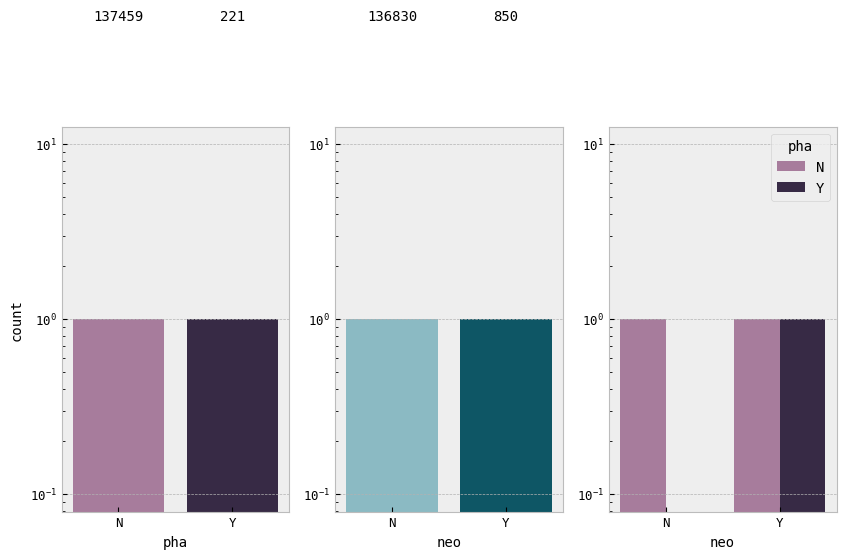

In [ ]:
def add_barlabel(rects, labels):
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 50, label, ha='center')

plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(131, yscale='log')
ax = sns.countplot(x=asteroid['pha'], palette=['#ae759f', '#372549'])
add_barlabel(ax.patches, asteroid['pha'].value_counts().values)

plt.subplot(132, yscale='log')
ax = sns.countplot(x=asteroid['neo'], palette=['#82c0cc', '#005f73'])
ax.set(ylabel=' ')
add_barlabel(ax.patches, asteroid['neo'].value_counts().values)

plt.subplot(133, yscale='log')
ax = sns.countplot(x=asteroid['neo'], hue=asteroid['pha'], palette=['#ae759f', '#372549'])
ax.set(ylabel=' ')

In [ ]:
import pandas as pd

# Assuming you have a DataFrame named 'asteroid' without a 'class' column
asteroid['class'] = 'Unknown'  # Assign a default class

# Example: Assign class based on albedo
asteroid.loc[asteroid['albedo'] < 0.1, 'class'] = 'Dark'
asteroid.loc[(asteroid['albedo'] >= 0.1) & (asteroid['albedo'] < 0.3), 'class'] = 'Intermediate'
asteroid.loc[asteroid['albedo'] >= 0.3, 'class'] = 'Bright'


In [ ]:
asteroid['class'].isnull().sum()

0

In [ ]:
pd.set_option('display.max_colwidth', None)

dic = {
    'MBA': ['Main-belt Asteroid',
            'Objects orbiting between Mars and Jupiter in the main portion of the asteroid belt.',
            '2.0 au < a < 3.2 au;  q > 1.666 au'],
    'OMB': ['Outer Main-belt Asteroid',
            'Objects orbiting between Mars and Jupiter in the outer reaches of the main asteroid belt.',
            '3.2 au < a < 4.6 au'],
    'TJN': ['Jupiter Trojan',
            "Objects trapped in Jupiter's L4/L5 in Lagrange points, share Jupiter's orbit around the sun.",
            '4.6 au < a < 5.5 au, e < 0.3'],
    'IMB': ['Inner Main-belt Asteroid',
            "Objects orbiting between Mars and Jupiter within the inner portion of the asteroid belt. ",
            'a < 2.0 au; q > 1.666 au'],
    'APO': ['Apollo',
            'Near-Earth asteroids whose orbit crosses the orbit of Earth.',
            'a > 1.0 au; q < 1.017 au'],
    'MCA': ['Mars-crossing Asteroids',
            'Objects with an orbit that crosses the orbit of Mars.',
            '1.3 au < q < 1.666 au; a < 3.2 au'],
    'AMO': ['Amor',
            'Near-Earth asteroids whose orbit approaches the orbit of Earth but does not cross it',
            'a > 1.0 au; 1.017 au < q < 1.3 au'],
    'ATE': ['Aten',
            'Near-Earth asteroids whose orbit could bring it in close proximity to Earth. ',
            'a < 1.0 au; ad > 0.983 au'],
    'CEN': ['Centaur',
            'Objects with an orbit between Jupiter and Neptune.',
            '5.5 au < a < 30.1 au'],
    'TNO': ['Trans-Neptunian Object',
            'Objects with orbits outside Neptune.',
            'a > 30.1 au'],
    'AST': ['Asteroid (other)',
            'Asteroid orbit not matching any defined orbit class.',
            ' ']
}

asteroid_classes = pd.DataFrame.from_dict(dic, columns=['Name','Description', 'Details'], orient='index')
asteroid_classes

,Name,Description,Details
MBA,Main-belt Asteroid,Objects orbiting between Mars and Jupiter in the main portion of the asteroid belt.,2.0 au < a < 3.2 au; q > 1.666 au
OMB,Outer Main-belt Asteroid,Objects orbiting between Mars and Jupiter in the outer reaches of the main asteroid belt.,3.2 au < a < 4.6 au
TJN,Jupiter Trojan,"Objects trapped in Jupiter's L4/L5 in Lagrange points, share Jupiter's orbit around the sun.","4.6 au < a < 5.5 au, e < 0.3"
IMB,Inner Main-belt Asteroid,Objects orbiting between Mars and Jupiter within the inner portion of the asteroid belt.,a < 2.0 au; q > 1.666 au
APO,Apollo,Near-Earth asteroids whose orbit crosses the orbit of Earth.,a > 1.0 au; q < 1.017 au
MCA,Mars-crossing Asteroids,Objects with an orbit that crosses the orbit of Mars.,1.3 au < q < 1.666 au; a < 3.2 au
AMO,Amor,Near-Earth asteroids whose orbit approaches the orbit of Earth but does not cross it,a > 1.0 au; 1.017 au < q < 1.3 au
ATE,Aten,Near-Earth asteroids whose orbit could bring it in close proximity to Earth.,a < 1.0 au; ad > 0.983 au
CEN,Centaur,Objects with an orbit between Jupiter and Neptune.,5.5 au < a < 30.1 au
TNO,Trans-Neptunian Object,Objects with orbits outside Neptune.,a > 30.1 au


In [ ]:
pd.set_option('display.max_colwidth', 50)

In [ ]:
asteroid['class'].value_counts()

class
Dark            80828
Intermediate    42674
Bright          12946
Unknown          1232
Name: count, dtype: int64

<ipython-input-17-8d77fb8feff6>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121, xscale='log', xlabel='diameter(km)')
<ipython-input-17-8d77fb8feff6>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122, xscale='log', xlabel='diameter(km)', ylabel=' ')


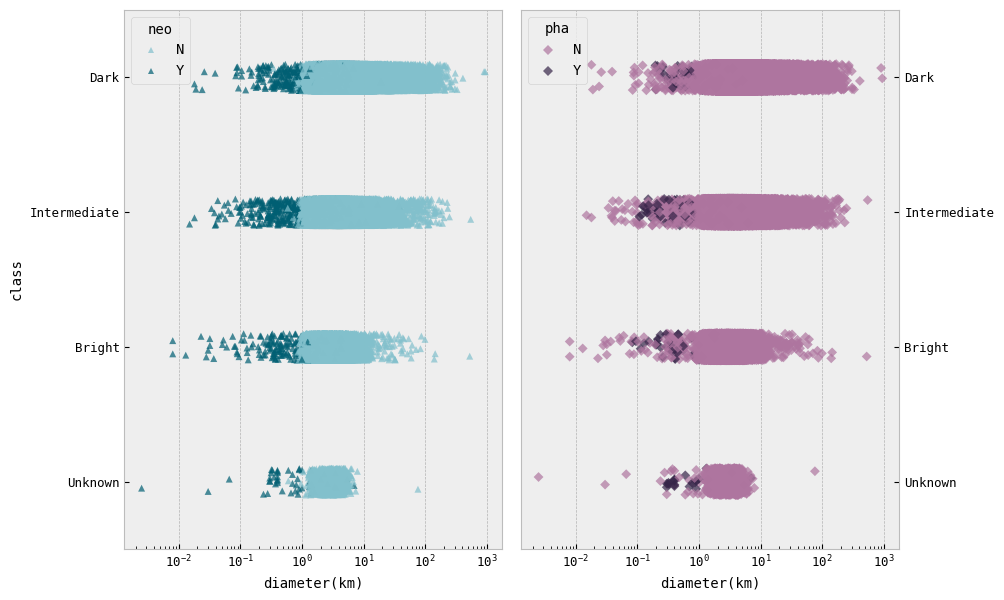

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,7))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xscale='log', xlabel='diameter(km)')
sns.stripplot(data=asteroid, x='diameter', y='class', hue='neo', marker='^', alpha=0.7,
             palette=['#82c0cc', '#005f73'])

plt.subplot(122, xscale='log', xlabel='diameter(km)', ylabel=' ')
sns.stripplot(data=asteroid, x='diameter', y='class', hue='pha', marker='D', alpha=0.7,
             palette=['#ae759f', '#372549'])
plt.gca().yaxis.tick_right()

In [ ]:
asteroid[['class','neo']].value_counts()

class         neo
Dark          N      80530
Intermediate  N      42329
Bright        N      12788
Unknown       N       1183
Intermediate  Y        345
Dark          Y        298
Bright        Y        158
Unknown       Y         49
Name: count, dtype: int64

[None, Text(0.5, 0, 'diameter (km)'), Text(0, 0.5, ' '), (0.01, 1)]

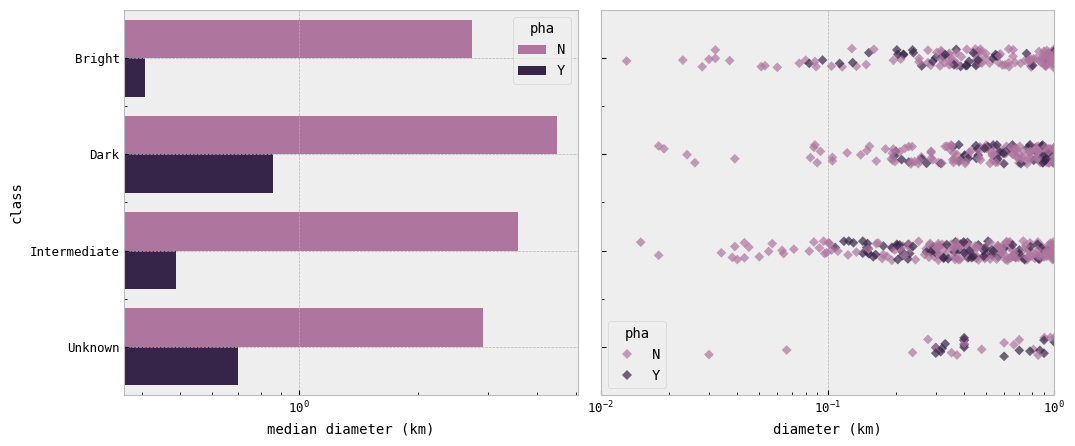

In [ ]:
# Calculate median diameter w.r.t. class and pha flag.
grp = asteroid[['class','pha','diameter']].groupby(['class','pha']).median()

fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
plt.subplots_adjust(wspace=0.05)

grp.unstack().plot(kind='barh', width=.8, color=['#ae759f', '#372549'], ax=ax[0])
ax[0].set(xscale='log', xlabel='median diameter (km)')
ax[0].legend(['N','Y'], title='pha')

sns.stripplot(data=asteroid.sort_values('class'), x='diameter', y='class', hue='pha', marker='D',
              alpha=0.7, palette=['#ae759f', '#372549'], ax=ax[1])
ax[1].set(xscale='log', xlabel='diameter (km)', ylabel=' ', xlim=(0.01, 1))

In [ ]:
asteroid.columns = asteroid.columns.str.strip()


In [ ]:
print(asteroid.columns)


Index(['a', 'e', 'G', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc',
       'condition_code', 'n_obs_used', 'H', 'diameter', 'extent', 'albedo',
       'rot_per', 'GM', 'BV', 'UB', 'IR', 'spec_B', 'spec_T', 'neo', 'pha',
       'moid', 'class'],
      dtype='object')


In [ ]:
print(asteroid.shape)  # Print the number of rows and columns
print(asteroid.head())  # Print the first few rows of the DataFrame

(137680, 27)
          a         e     G          i          om           w         q  \
0  2.769165  0.076009  0.12  10.594067   80.305532   73.597694  2.558684   
1  2.772466  0.230337  0.11  34.836234  173.080063  310.048857  2.133865   
2  2.669150  0.256942  0.32  12.988919  169.852760  248.138626  1.983332   
3  2.361418  0.088721  0.32   7.141771  103.810804  150.728541  2.151909   
4  2.574249  0.191095   NaN   5.366988  141.576604  358.687608  2.082324   

         ad     per_y  data_arc  ...       GM     BV     UB  IR spec_B  \
0  2.979647  4.608202    8822.0  ...  62.6284  0.713  0.426 NaN      C   
1  3.411067  4.616444   72318.0  ...  14.3000  0.635  0.284 NaN      B   
2  3.354967  4.360814   72684.0  ...      NaN  0.824  0.433 NaN     Sk   
3  2.570926  3.628837   24288.0  ...  17.8000  0.782  0.492 NaN      V   
4  3.066174  4.130323   63431.0  ...      NaN  0.826  0.411 NaN      S   

   spec_T  neo  pha     moid         class  
0       G    N    N  1.59478          Da

In [ ]:

asteroid.full_name.unique()[10000:]

AttributeError: 'DataFrame' object has no attribute 'full_name'

In [ ]:
asteroid = asteroid.drop(['name'], axis=1)

KeyError: "['name'] not found in axis"

In [ ]:
asteroid.a.isnull().sum()

0

Text(0.5, 0, '')

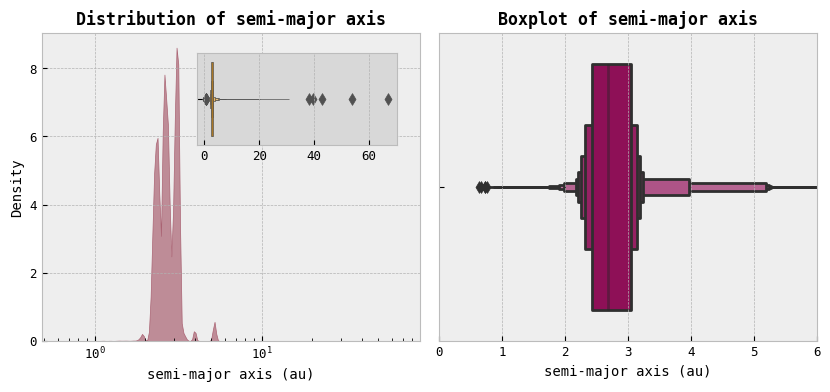

In [ ]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xlabel='semi-major axis (au)', title='Distribution of semi-major axis')
sns.kdeplot(data=asteroid, x='a',fill=True, log_scale=True,  color='#aa6373', alpha=.7)

plt.subplot(122, title='Boxplot of semi-major axis', xlim=(0,6))
sns.boxenplot(data=asteroid, x='a', saturation=.8, color='#9e0059')
plt.gca().set(xlabel='semi-major axis (au)')

fig.add_axes([0.28,0.6,0.20,0.23])
zoom_out_ax = sns.boxenplot(data=asteroid, x='a', saturation=.8, color='#fca311', linewidth=.5)
zoom_out_ax.set_facecolor('#D8D8D8')
plt.xlabel('')

<ipython-input-30-d6c05f8262df>:4: UserWarning: The palette list has more values (11) than needed (4), which may not be intended.
  sns.scatterplot(data=asteroid, x='a', y='diameter', hue='class', palette=classes_palette, ax=ax[0])


[Text(0.5, 0, 'semi-major axis (au)'), None]

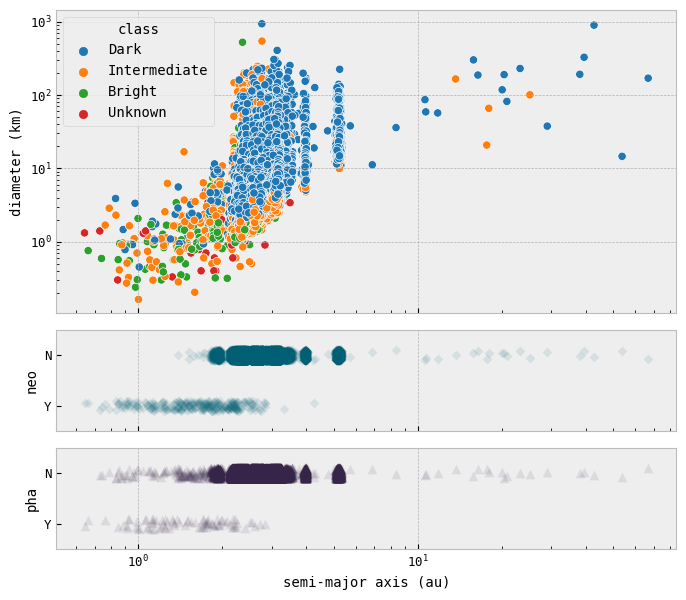

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,7), gridspec_kw={'height_ratios': [3,1,1]}, sharex=True)
plt.subplots_adjust(hspace=0.1)

sns.scatterplot(data=asteroid, x='a', y='diameter', hue='class', palette=classes_palette, ax=ax[0])
ax[0].set(ylabel='diameter (km)', xscale='log', yscale='log')

sns.stripplot(data=asteroid, x='a', y='neo', marker='D', s=5, alpha=.1,
              jitter=True, color='#005f73',edgecolor='#001524', ax=ax[1])
ax[1].set(xscale='log')

sns.stripplot(data=asteroid, x='a', y='pha', marker='^', s=7, alpha=.1,
              jitter=True, color='#372549', edgecolor='#001524', ax=ax[2])
ax[2].set(xlabel='semi-major axis (au)', xscale='log')